In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.text as text
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
import matplotlib.style
matplotlib.style.use('seaborn')
import pathos.pools
from datetime import datetime
import sys, controller
from pendulum import simRunner, Pendulum, Simulation

In [4]:
sr = simRunner()
a=0.5
params = {
    # pendulum
    'pend_rand': True,
    'M' : 5,
    'm' : 3,
    'l' : 3,
    'M_low' : 1,
    'M_high': 10,
    'm_low' : 1,
    'm_high': 8,
    'l_low' : 1,
    'l_high': 8,
    # sim
    'simtime' : 8,
    'force' : lambda t: 1/(0.5*np.sqrt(np.pi))*np.exp(-((t-1.5)/0.5)**2),
    # control
    'window' : 3,
    'measure_n': 4
}


In [14]:
results = sr.run_many(4, params, 2)
labels = ['x','xd','theta','thetad']    
data = pd.concat(
    [
        pd.DataFrame.from_records(np.abs(results['ldiff'].values), columns=labels, index=results.index),
        pd.DataFrame.from_records(np.abs(results['nldiff'].values), columns=labels, index=results.index),
        pd.DataFrame.from_records(np.abs(results['ldiff_n'].values), columns=labels, index=results.index),
        pd.DataFrame.from_records(np.abs(results['nldiff_n'].values), columns=labels, index=results.index),
        pd.DataFrame.from_records(results['state'].values, columns=labels, index=results.index),
        pd.DataFrame.from_records(results['mu'].values, columns=labels, index=results.index),
        pd.DataFrame.from_records(results['sigma'].values, columns=labels, index=results.index)
    ],
    axis=1,
    keys = ['ldiff', 'nldiff', 'ldiff_n', 'nldiff_n', 'state', 'mu', 'sigma']
)

simulating 4 runs


ValueError: non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (0,)

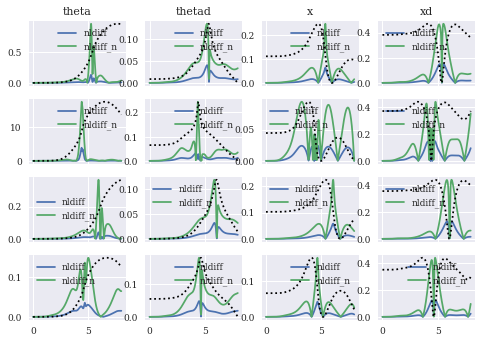

In [11]:
varnames = []
fig3, axs3 = plt.subplots(nrows=len(data.groupby(level=0)), ncols=len(data.groupby(level=1, axis=1)), sharex=True)  
# group by run; one row for each run.
for i, (_, dfi) in enumerate(data.iloc[::10].groupby(level=0)):
    dfi = dfi.droplevel(0)[['state', 'nldiff', 'nldiff_n']]
    # group by col; one col for each state var
    for j, (xj, dfj) in enumerate(dfi.groupby(level=1, axis=1)):
        dfj = dfj.droplevel(1, axis=1)
        for k in dfj.columns:
            if k == 'state':
                varnames.append(xj)
                state_axis = axs3[i,j].twinx()
                state_axis.set_frame_on(True)
                state_axis.patch.set_visible(False)
                state_axis.grid(False)
                state_axis.get_yaxis().set_visible(False)
                state_axis.plot(dfj[k], 'k:', label=str(k))
            else:
                axs3[i, j].plot(dfj[k], label=str(k))
        axs3[i, j].legend()
for j, vname in zip(axs3[0,:], varnames):
    j.set_title(vname)
plt.show()

                ldiff                                                  nldiff  \
                    x            xd         theta        thetad             x   
0 0.000  7.910095e-12  1.976929e-08  1.748364e-12  4.369597e-09  7.910095e-12   
  0.001  3.239331e-11  3.977706e-08  7.159881e-12  8.791914e-09  3.239331e-11   
  0.002  7.364953e-11  6.002607e-08  1.627874e-11  1.326756e-08  7.364953e-11   
  0.003  1.318809e-10  8.051908e-08  2.914963e-11  1.779716e-08  1.318809e-10   
  0.004  2.072920e-10  1.012589e-07  4.581779e-11  2.238134e-08  2.072920e-10   
...               ...           ...           ...           ...           ...   
3 7.995  4.173856e-03  2.483848e-02  1.735639e-01  6.258246e-02  3.188328e-03   
  7.996  4.860644e-03  2.790522e-02  1.718771e-01  6.468858e-02  2.501539e-03   
  7.997  5.544870e-03  3.098646e-02  1.701886e-01  6.679617e-02  1.817313e-03   
  7.998  6.226523e-03  3.408222e-02  1.684983e-01  6.890525e-02  1.135661e-03   
  7.999           NaN       

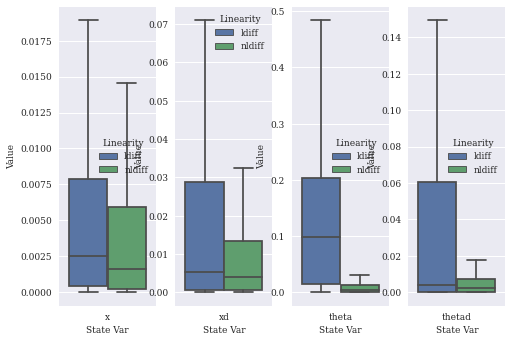

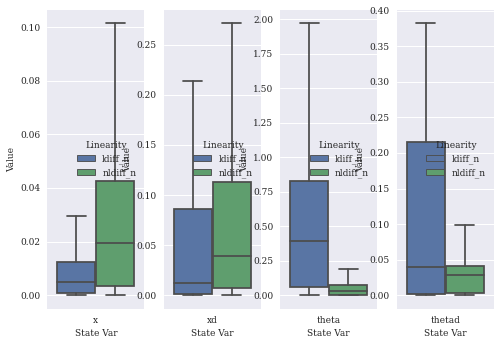

In [7]:
print(data)
idx = pd.IndexSlice
fig1, axs1 = plt.subplots(nrows=1, ncols=4)
fig2, axs2 = plt.subplots(nrows=1, ncols=4)
for label, ax in zip(labels, axs1.flat):
    long_data = data.droplevel(0).loc[:, idx[['ldiff','nldiff'],label]].stack().reset_index(level=1)
    long_data = long_data.melt(id_vars=['level_1'], value_vars=['ldiff', 'nldiff'], var_name='Linearity', value_name='Value')
    sns.boxplot(data=long_data, x='level_1', y='Value', hue='Linearity', ax=ax, showfliers=False, width=0.8)
    ax.set_ylabel('Value')
    ax.set_xlabel('State Var')

for label, ax in zip(labels, axs2.flat):
    long_data = data.droplevel(0).loc[:, idx[['ldiff_n', 'nldiff_n'], label]].stack().reset_index(level=1)
    long_data = long_data.melt(id_vars=['level_1'], value_vars=['ldiff_n', 'nldiff_n'], var_name='Linearity', value_name='Value')
    sns.boxplot(data=long_data, x='level_1', y='Value', hue='Linearity', ax=ax, showfliers=False, width=0.8)
    ax.set_ylabel('Value')
    ax.set_xlabel('State Var')
plt.show()